In [2]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
from matplotlib import cm

# Reliability
from reliability.Fitters import Fit_Everything, Fit_Weibull_3P
from reliability.Reliability_testing import KStest
from reliability.Distributions import Weibull_Distribution, Lognormal_Distribution, Exponential_Distribution
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# Utilities
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [3]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file',filepath, 'this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ
  
            tuples.append(tup)
        
        df_sens = pd.DataFrame(data = {'Window' : c_wins, 'Tuples' : tuples})
        df_sens.to_csv(filepath)

    else:
        print('File already exists!\n')
        df_sens = pd.read_csv(filepath, index_col = 0)
    
    return df_sens      

In [4]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file', filepath, 'this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in range(dataframe.shape[0]-1):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)

    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
    
    return dataframe

In [5]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
    df_temp = df_temp.append(df_stat, ignore_index = True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

## Load Data

In [6]:
df_bgl = pd.read_csv('./BGLErrorLog.txt', names = ['Timestamp', 'ID-Node','Rack', 'Midplane', 'Node', 'Card', 'Card type', 'Message'])

df_bgl.loc[:,'ID-Node'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[1]

df_bgl.loc[:,'Rack'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[0]
df_bgl.loc[:,'Midplane'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[1]
df_bgl.loc[:,'Node'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[2]

df_bgl.loc[:,'Card'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[2]

df_bgl.loc[df_bgl['Card'].str.contains('J18'),'Card type'] = 'I-O'
df_bgl.loc[~df_bgl['Card'].str.contains('J18'),'Card type'] = 'computation'

# df_bgl.loc[:,'Card type'] = df_bgl.loc[:,'Card'].str.split('-', n=1).str[0]

df_bgl.loc[:,'Message'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[3].str.strip()
df_bgl.loc[:,'Timestamp'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

print('Log file has ' + str(df_bgl.shape[0]) + ' entries and ' + str(df_bgl.shape[1]) + ' columns.')
df_bgl.head()

c:\Users\eleun\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Log file has 125624 entries and 8 columns.


,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,I-O,Lustre mount FAILED : bglio2 : block_id : loca...
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,I-O,Lustre mount FAILED : bglio21 : block_id : loc...
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,I-O,Lustre mount FAILED : bglio124 : block_id : lo...
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio4 : block_id : loca...
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio36 : block_id : loc...


# System (Blue Gene/L)

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

File already exists!



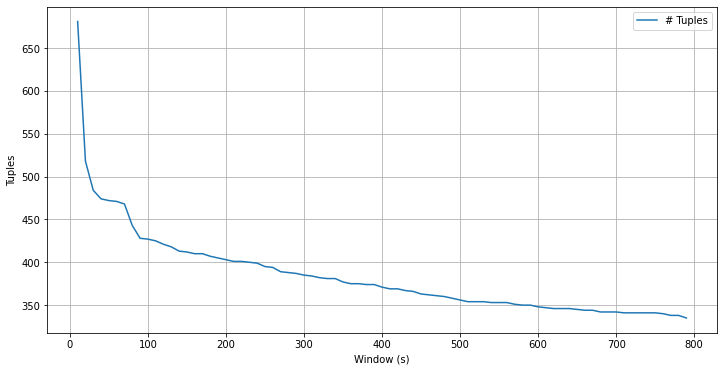

In [7]:
c_wins = np.delete(np.arange(0,800,10), 0)

filepath = './data/system/BGL-Sensitivity.csv'

df_bgl_sensitivity = sensitivity_analysis(df_bgl, c_wins, filepath)

plt.figure(figsize=(12,6))
plt.plot(df_bgl_sensitivity['Window'],df_bgl_sensitivity['Tuples'], label = '# Tuples')
plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()
plt.savefig("./img/system/BGL_System_Sensitivity.png", format = "png")
plt.show()

#### Tupling

In [8]:
window = 200

filepath = './data/system/BGL-Data.csv'

df_bgl = tupling(df_bgl, window, filepath)
df_bgl = df_bgl.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bgl.head()

File already exists!



,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message,Tuple
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,I-O,Lustre mount FAILED : bglio2 : block_id : loca...,0
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,I-O,Lustre mount FAILED : bglio21 : block_id : loc...,0
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,I-O,Lustre mount FAILED : bglio124 : block_id : lo...,0
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio4 : block_id : loca...,0
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio36 : block_id : loc...,0


In [9]:
num_tuple = df_bgl.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  403


C:\Users\eleun\AppData\Local\Temp/ipykernel_6204/2052055457.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  num_tuple = df_bgl.max(axis = 0).loc['Tuple'] + 1


In [10]:
df_sys_stat = statistics(df_bgl)
df_sys_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,128,1128621350,1128621367,17,7.52941,NaN
1,1024,1128641281,1128641411,130,7.87692,19914
2,23,1128702415,1128702464,49,0.469388,61004
3,9,1128719240,1128719316,76,0.118421,16776
4,14,1128747957,1128748024,67,0.208955,28641


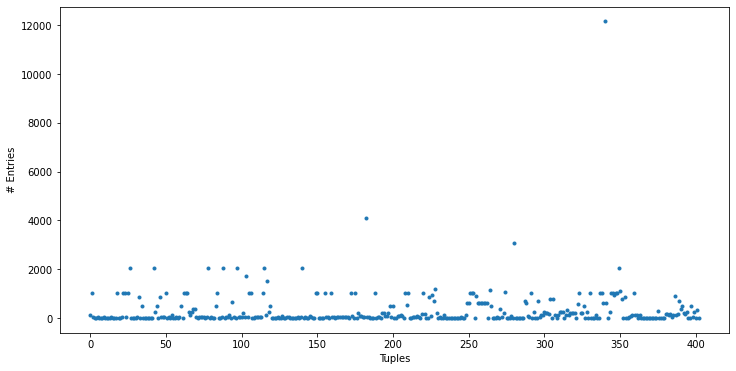

In [11]:
x = df_sys_stat.index
y = df_sys_stat['# Entries']

plt.figure(figsize=(12,6))
plt.scatter(x, y, marker = '.')
plt.xlabel('Tuples')
plt.ylabel('# Entries')
plt.savefig("./img/system/BGL_System_Scatter_Entry.png", format = "png")
plt.show()

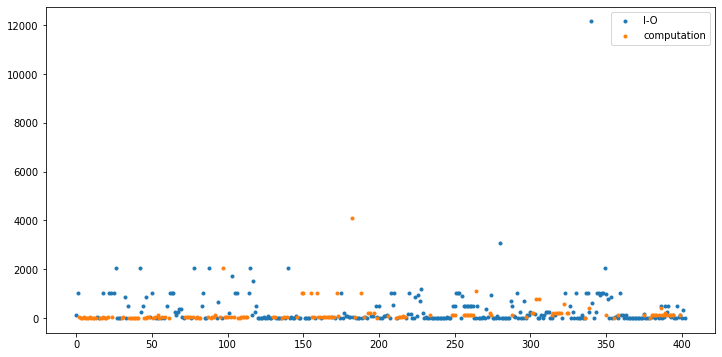

In [12]:
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()

# cmap = cm.get_cmap('tab20')
# colors = cmap.colors

fig, ax = plt.subplots(figsize=(12,6))
# ax.set_prop_cycle(color=colors)

for card in df_bgl['Card type'].unique():
    df_temp = df_group[df_group.index.get_level_values('Card type').isin([card])]
    
    x = df_temp.index.get_level_values(0)
    y = df_temp['Timestamp']
    
    plt.scatter(x,y, label=card, marker = '.')

    
plt.legend()
plt.savefig("./img/system/BGL_System_Scatter_CardType.png", format = "png")
plt.show()


In [13]:
a = df_bgl.groupby(by='Card type').Timestamp.count().sort_values(ascending=False)
N = df_bgl.Timestamp.count()
print(a)
print(a["I-O"] / N)
print(a["computation"] / N)

Card type
I-O            99987
computation    25637
Name: Timestamp, dtype: int64
0.7959227536139591
0.20407724638604088


### Truncation analysis

In [14]:
q = df_sys_stat['Interarrival'].quantile(q=0.1)
print("0.1 quantile: " + str(q))

0.1 quantile: 451.90000000000003


In [15]:
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]
df_trunc.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
11,1,1128868257,1128868257,0,inf,406
20,1,1129098173,1129098173,0,inf,397
29,1,1129223561,1129223561,0,inf,438
33,8,1129289944,1129289945,1,8,284
67,256,1129922826,1129922853,27,9.48148,320


In [16]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100

print('Estimate number of truncations:', num_trunc)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 41
Estimate percentage of truncations: 10.173697270471465


### Collision analysis

In [17]:
df_group = df_bgl.groupby(by=['Tuple','Rack']).count()
df_group = df_group.reset_index(level = 1)

collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [18]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 185
Estimate percentage of collisions:  45.90570719602978


In [19]:
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()
df_group = df_group.reset_index(level = 1)

collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [20]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 39
Estimate percentage of collisions:  9.67741935483871


## Data Analysis

### Empirical time to failure distribution

### Empirical reliability

In [21]:
data_bgl = df_sys_stat['Interarrival'].dropna().to_numpy()

ecdf = ECDF(data_bgl)

tempi_int = pd.DataFrame(df_sys_stat['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
np.savetxt(r'./scripts_matlab/system/tempi_int.txt', tempi_int, fmt='%d')

# Top Racks

In [22]:
print('Number of racks that generates error: ' + str(len(df_bgl['Rack'].unique())))

Number of racks that generates error: 64


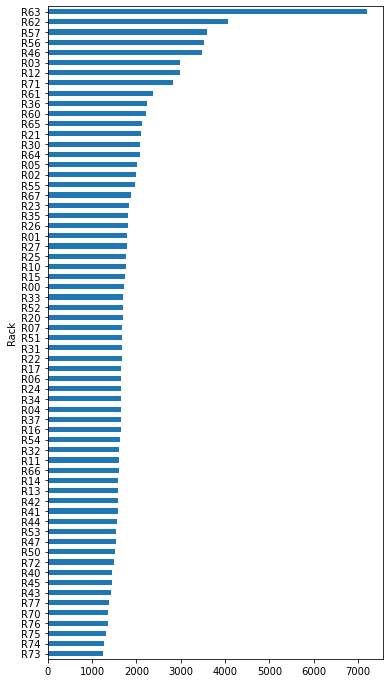

In [23]:
plt.figure(figsize=(6,12))
df_bgl.groupby(by='Rack').Timestamp.count().sort_values().plot.barh()
plt.savefig("./img/components/BGL_System_Bar_Rack.png", format = "png")
plt.show()

Il sistema è fatto da 64 rack e gli errori sono distribuiti come nella figura sopra.
sotto si estraggono gli n rack con piu falliemnti, per fare analisi per i rack piu problematici.

In [24]:
n = 8 # l'ho provato per i primi 8 perché c'era roba interessante, pero poi le reliability fanno un po schifo
top_rack = df_bgl.groupby(by=['Rack']).Timestamp.count().sort_values(ascending=False)[0:n].index

df_top_rack = df_bgl.loc[df_bgl['Rack'] == top_rack[0]]
for r in range(1,n):
    df_top_rack = df_top_rack.append(df_bgl.loc[df_bgl['Rack'] == top_rack[r]])

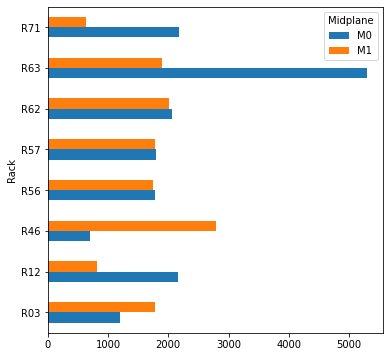

In [25]:
# df_bgl.groupby(by=['Rack', 'Midplane']).Timestamp.count().unstack(1).plot.barh(figsize=(6,15))
df_top_rack.groupby(by=['Rack', 'Midplane']).Timestamp.count().unstack(1).plot.barh(figsize=(6,6))
plt.savefig("./img/components/BGL_Rack_Bar_Rack_Midplane.png", format = "png")
plt.show()

ogni rack ha 2 midplane. gli errori trai midplane sono piu o meno bilanciati tranne qualcuno.
il 63 che rompe il cazzo piu di tutti ha un midplain che va a puttane.

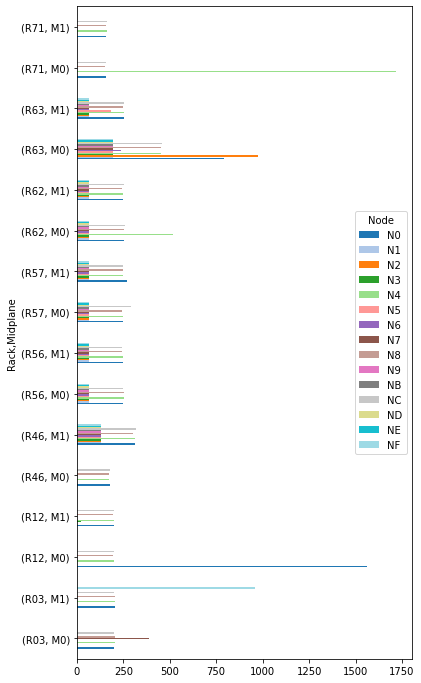

Node            N0  N1  N2  N3  ...  NC  ND  NE  NF
Rack Midplane                   ...                
R03  M0        202 NaN NaN NaN  ... 202 NaN NaN NaN
     M1        205 NaN NaN NaN  ... 202 NaN NaN 960
R12  M0       1563 NaN NaN NaN  ... 199 NaN NaN NaN
     M1        199 NaN NaN  24  ... 199 NaN NaN NaN
R46  M0        179 NaN NaN NaN  ... 176 NaN NaN NaN
     M1        313 128 128 128  ... 320 128 128 128
R56  M0        250  64  64  64  ... 249  64  64  64
     M1        246  64  64  64  ... 245  64  64  64
R57  M0        248  64  64  64  ... 292  64  64  64
     M1        268  64  64  64  ... 248  64  64  64
R62  M0        254  64  64  64  ... 261  64  64  64
     M1        249  64  64  64  ... 252  64  64  64
R63  M0        791 192 976 192  ... 460 192 194 192
     M1        253  64  64  64  ... 255  64  64  64
R71  M0        157 NaN NaN NaN  ... 156 NaN NaN NaN
     M1        158 NaN NaN NaN  ... 160 NaN NaN NaN

[16 rows x 15 columns]

In [26]:
# df_bgl.groupby(by=['Rack', 'Midplane', 'Node']).Timestamp.count().unstack(2).plot.barh(figsize=(15,35), cmap = 'tab20')
df_top_rack.groupby(by=['Rack', 'Midplane', 'Node']).Timestamp.count().unstack(2).plot.barh(figsize=(6,12), cmap = 'tab20')
plt.savefig("./img/components/BGL_Rack_Bar_Rack_Midplane_Node.png", format = "png")
plt.show()
df_top_rack.groupby(by=['Rack', 'Midplane', 'Node']).Timestamp.count().unstack(2)

sicuramente è più leggibile se fatto solo per i top 5 rack, ma cmq si nota che:
- r63 fa cacare un po tutto, non c è un singolo nodo che si sputtana
- r71 ha il nodo con piu fallimenti di tutto il sistema, tipo un N4 che fa IO
- r12 pure non scherza, sempre un nodo di IO (N0)
- r03 pure si rompe un nodo di computation
- tutti i nodi hanno errori sui 4 nodi che hanno scheda di IO (azzurro n0 verde n4 marrone n8 ocra nC)

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [27]:
c_wins = np.delete(np.arange(0,500,1), 0)

for rack in top_rack:
    df_temp = df_bgl.loc[df_bgl['Rack'] == rack]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/components/BGL-' + rack + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

Creating file ./data/components/BGL-R63-Sensitivity.csv this may take a while...

Creating file ./data/components/BGL-R62-Sensitivity.csv this may take a while...

Creating file ./data/components/BGL-R57-Sensitivity.csv this may take a while...

Creating file ./data/components/BGL-R56-Sensitivity.csv this may take a while...

Creating file ./data/components/BGL-R46-Sensitivity.csv this may take a while...

Creating file ./data/components/BGL-R03-Sensitivity.csv this may take a while...

Creating file ./data/components/BGL-R12-Sensitivity.csv this may take a while...

Creating file ./data/components/BGL-R71-Sensitivity.csv this may take a while...



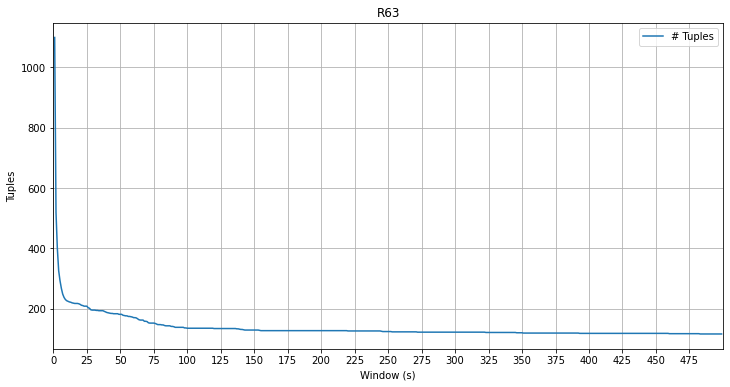

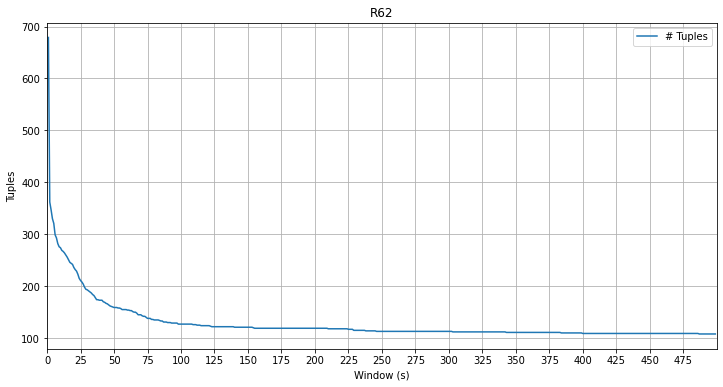

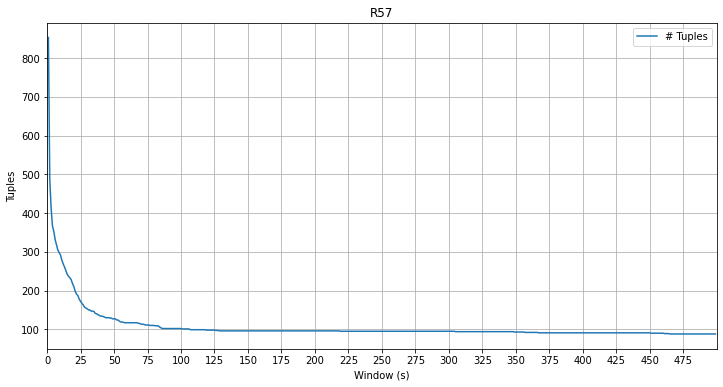

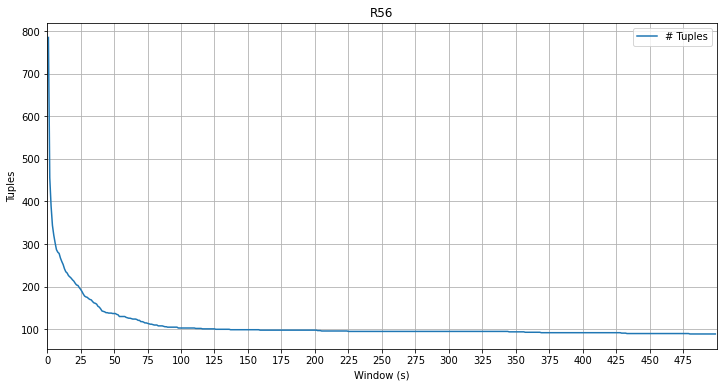

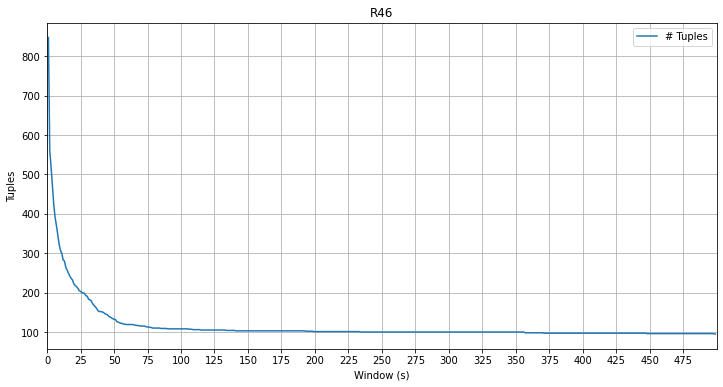

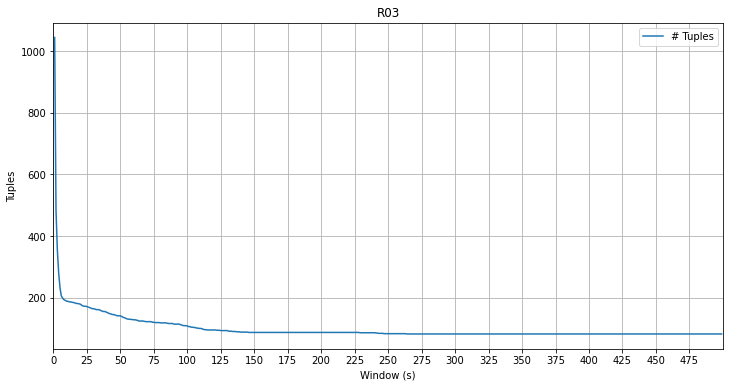

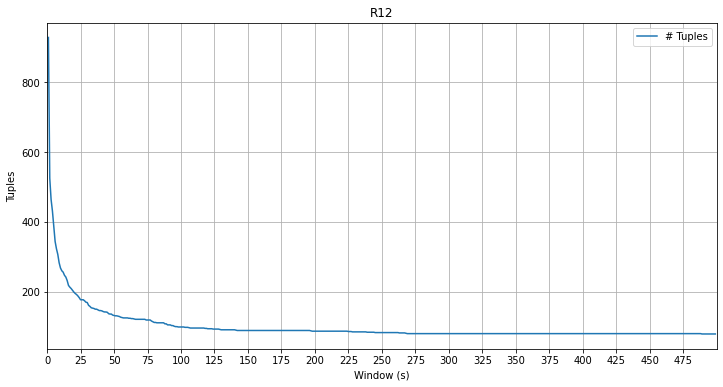

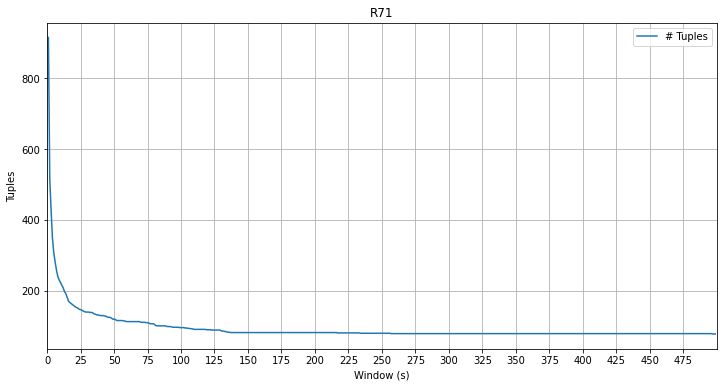

In [29]:
for rack in top_rack:
    filepath = './data/components/BGL-' + rack + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(rack)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./img/components/BGL_Rack_Sensitivity_" + rack + ".png", format = "png")
    plt.show()

In [30]:
win_dict = {'R63' : 75,
            'R62' : 75,
            'R56' : 75,
            'R57' : 75,
            'R46' : 75,
            'R03' : 75,
            'R12' : 75,
            'R71'  : 75}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'R63': 75, 'R62': 75, 'R56': 75, 'R57': 75, 'R46': 75, 'R03': 75, 'R12': 75, 'R71': 75}


#### Tupling

In [31]:
dict_df_rack_stat = {}
dict_rack_num_tup = {}

for rack in top_rack:
    df_temp = df_bgl.loc[df_bgl['Rack'] == rack]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/components/BGL-' + rack + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[rack], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_rack_num_tup[rack] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_rack_stat[rack] = df_stat

print('Number of tuples:', dict_rack_num_tup)

Creating file ./data/components/BGL-R63-Data.csv this may take a while...



c:\Users\eleun\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\eleun\AppData\Local\Temp/ipykernel_6204/751595383.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1


Creating file ./data/components/BGL-R62-Data.csv this may take a while...

Creating file ./data/components/BGL-R57-Data.csv this may take a while...

Creating file ./data/components/BGL-R56-Data.csv this may take a while...

Creating file ./data/components/BGL-R46-Data.csv this may take a while...

Creating file ./data/components/BGL-R03-Data.csv this may take a while...

Creating file ./data/components/BGL-R12-Data.csv this may take a while...

Creating file ./data/components/BGL-R71-Data.csv this may take a while...

Number of tuples: {'R63': 153, 'R62': 138, 'R57': 111, 'R56': 114, 'R46': 113, 'R03': 120, 'R12': 119, 'R71': 109}


## Data Analysis

### Empirical reliability

In [32]:
for rack in top_rack:

    ecdf = ECDF(dict_df_rack_stat[rack]['Interarrival'].dropna())

    tempi_int = pd.DataFrame(dict_df_rack_stat[rack]['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
    np.savetxt(r'./scripts_matlab/components/tempi_int'+rack+'.txt', tempi_int, fmt='%d')

df = pd.DataFrame(top_rack)
df.to_excel('./scripts_matlab/components/names.xls')


C:\Users\eleun\AppData\Local\Temp/ipykernel_6204/4251877771.py:9: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel('./scripts_matlab/components/names.xls')


# Card Types

In [33]:
types = df_bgl['Card type'].unique()

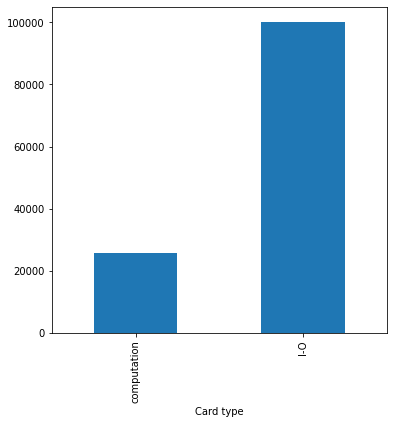

In [36]:
plt.figure(figsize=(6,6))
df_bgl.groupby(by='Card type').Timestamp.count().sort_values().plot.bar(figsize=(6,6))
plt.savefig("./img/types/BGL_Card_Bar_Type.png", format = "png")
plt.show()

sopra si vede che fondamentamente ci sono problemi con il sistema di IO.

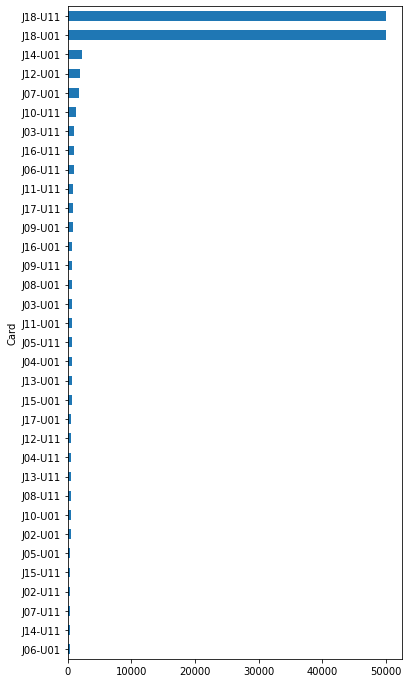

In [38]:
plt.figure(figsize=(6,12))
df_bgl.groupby(by='Card').Timestamp.count().sort_values().plot.barh(figsize=(6,12))
plt.savefig("./img/types/BGL_Card_Bar_Node.png", format = "png")
plt.show()

gli errori sono bilanciati tra le due card di ogni tipologia.

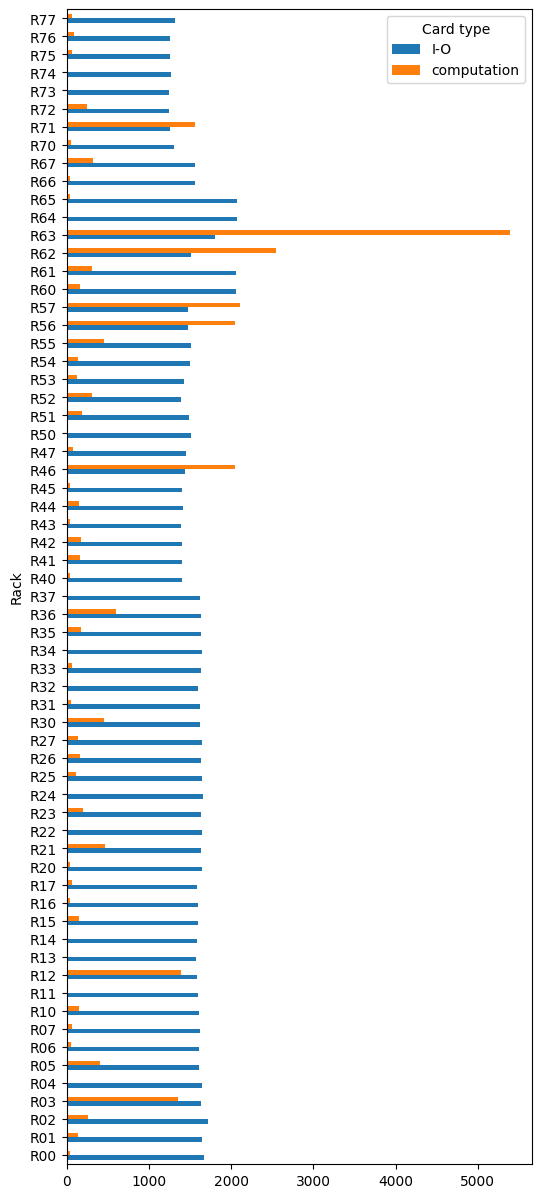

In [28]:
df_bgl.groupby(by=['Rack','Card type']).Timestamp.count().unstack(1).plot.barh(figsize=(6,15))
plt.savefig("./img/types/BGL_Card_Bar_Rack_Type.png", format = "png")
plt.show()

da questa immagine vediamo che i problemi di IO sono comuni a quasi tutti i rack.
un altro fatto interessante è che i rack più critici non hanno solo problemi con l'IO ma anche  con le card di computation

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [39]:
c_wins = np.delete(np.arange(0,500,1), 0)

for t in types:
    df_temp = df_bgl.loc[df_bgl['Card type'] == t]
    df_temp.reset_index(drop = True, inplace = True)
    
    filepath = './data/types/BGL-' + t + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

Creating file ./data/types/BGL-I-O-Sensitivity.csv this may take a while...

Creating file ./data/types/BGL-computation-Sensitivity.csv this may take a while...



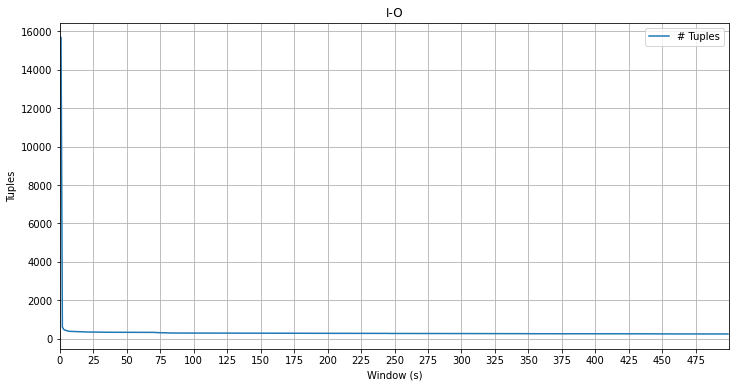

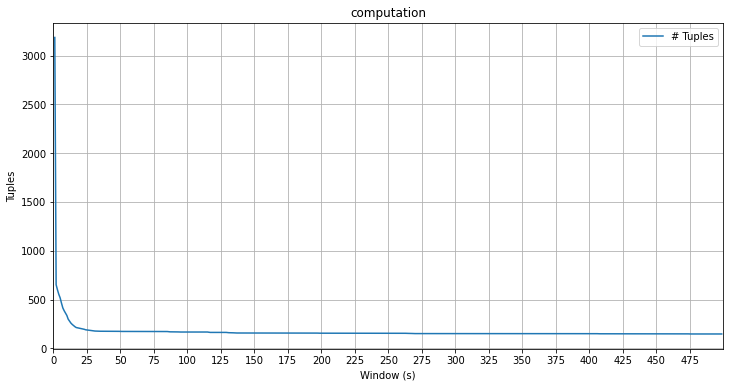

In [41]:
for t in types:
    filepath = './data/types/BGL-' + t + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(t)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./img/types/BGL_Card_Sensitivity" + t +".png", format = "png")
    plt.show()

In [42]:
win_dict = {'I-O' : 10,
            'computation' : 20}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'I-O': 10, 'computation': 20}


#### Tupling

In [43]:
dict_df_type_stat = {}
dict_type_num_tup = {}

for t in types:
    df_temp = df_bgl.loc[df_bgl['Card type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/types/BGL-' + t + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[t], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_type_num_tup[t] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_type_stat[t] = df_stat

print('Number of tuples:', dict_type_num_tup)

Creating file ./data/types/BGL-I-O-Data.csv this may take a while...



c:\Users\eleun\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Creating file ./data/types/BGL-computation-Data.csv this may take a while...

Number of tuples: {'I-O': 380, 'computation': 204}


C:\Users\eleun\AppData\Local\Temp/ipykernel_6204/950967665.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1


## Data Analysis

### Empirical reliability

In [34]:
for t in types:

    ecdf = ECDF(dict_df_type_stat[t]['Interarrival'].dropna())

    tempi_int = pd.DataFrame(dict_df_type_stat[t]['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
    np.savetxt(r'./scripts_matlab/types/tempi_int'+t+'.txt', tempi_int, fmt='%d')

df = pd.DataFrame(types)
df.to_excel('./scripts_matlab/types/names.xls')


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1442999936.py:9: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel('./scripts_matlab/types/names.xls')


# Top Nodes

In [35]:
print('Number of nodes that generates error: ' + str(len(df_bgl['ID-Node'].unique())))

Number of nodes that generates error: 698


In [36]:
n = 5

top_node = df_bgl.groupby(by=['ID-Node']).Timestamp.count().sort_values(ascending=False)[0:n].index

df_top_node = df_bgl.loc[df_bgl['ID-Node'] == top_node[0]]
for r in range(1,n):
    df_top_node = df_top_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_node[r]])

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1494793635.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_node = df_top_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_node[r]])
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1494793635.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_node = df_top_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_node[r]])
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1494793635.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_top_node = df_top_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_node[r]])
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1494793635.py:7: FutureWarning: The frame.append me

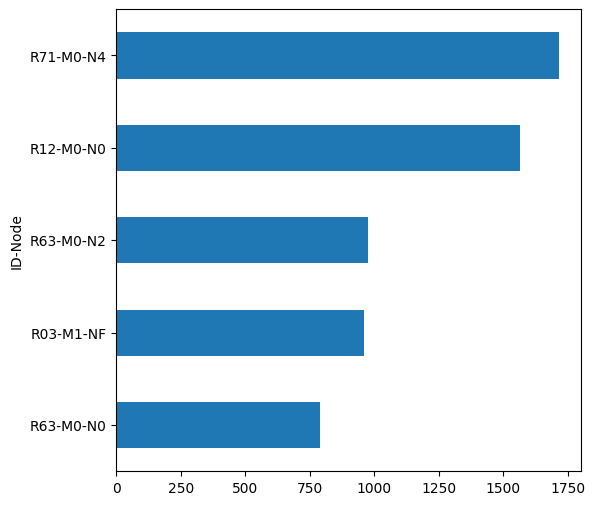

In [37]:
df_top_node.groupby(by='ID-Node').Timestamp.count().sort_values(ascending=True).plot.barh(figsize=(6,6))
plt.savefig("./img/nodes/BGL_Node_Bar.svg", format = "svg")
plt.show()

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

In [38]:
c_wins = np.delete(np.arange(0,500,1), 0)

for node in top_node:
    df_temp = df_bgl.loc[df_bgl['ID-Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/nodes/BGL-' + node + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



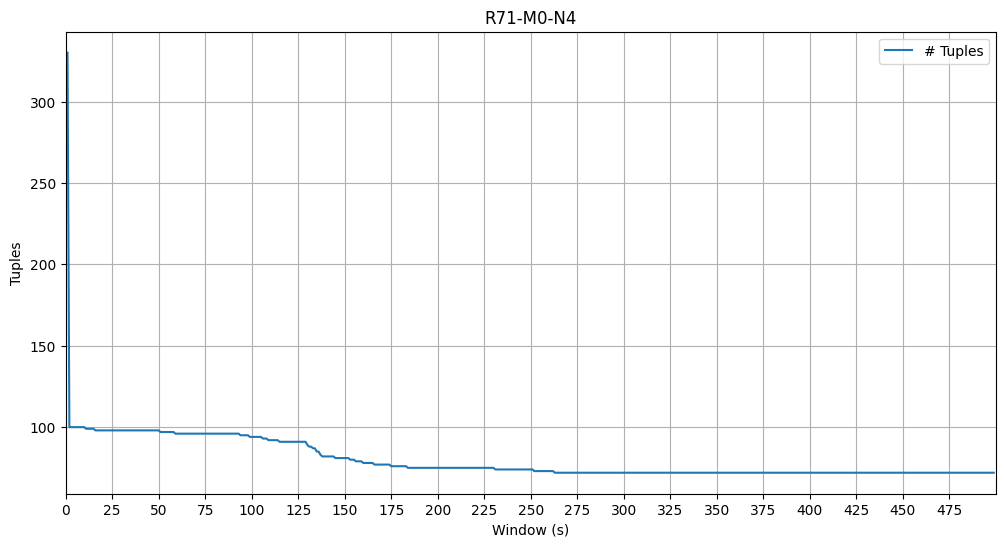

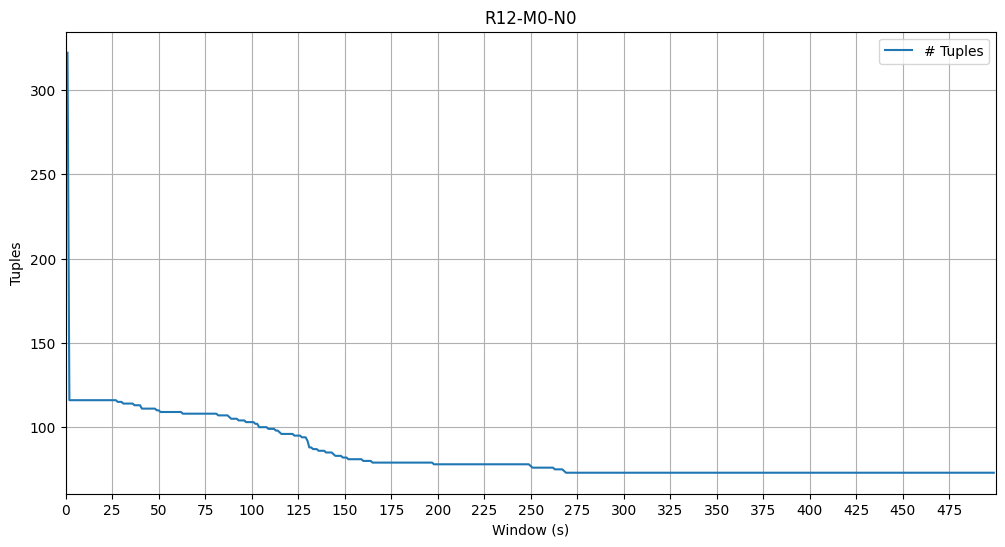

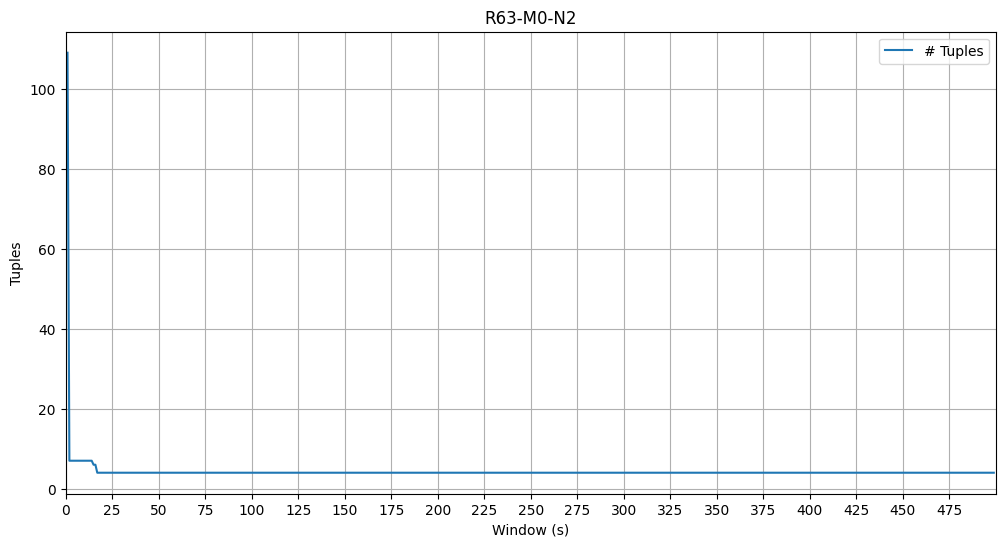

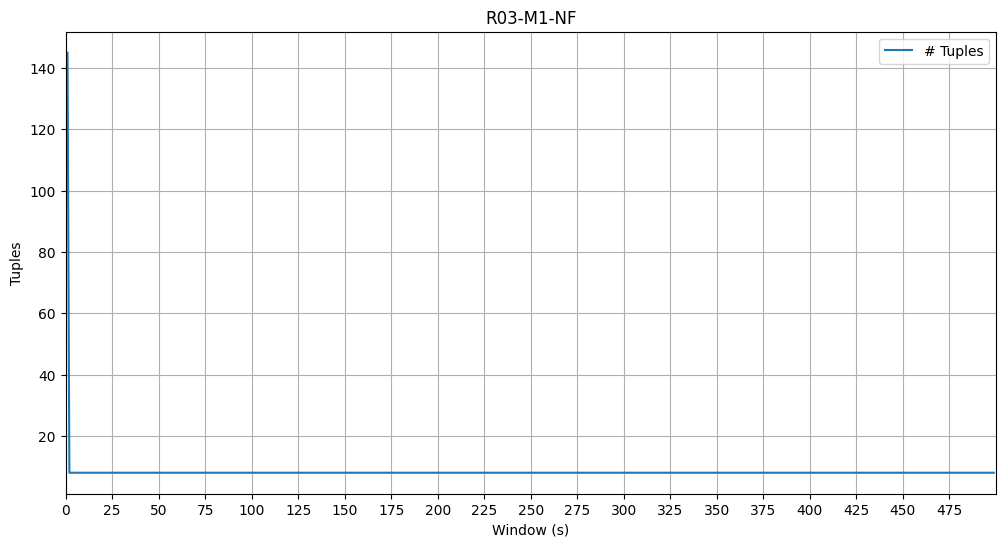

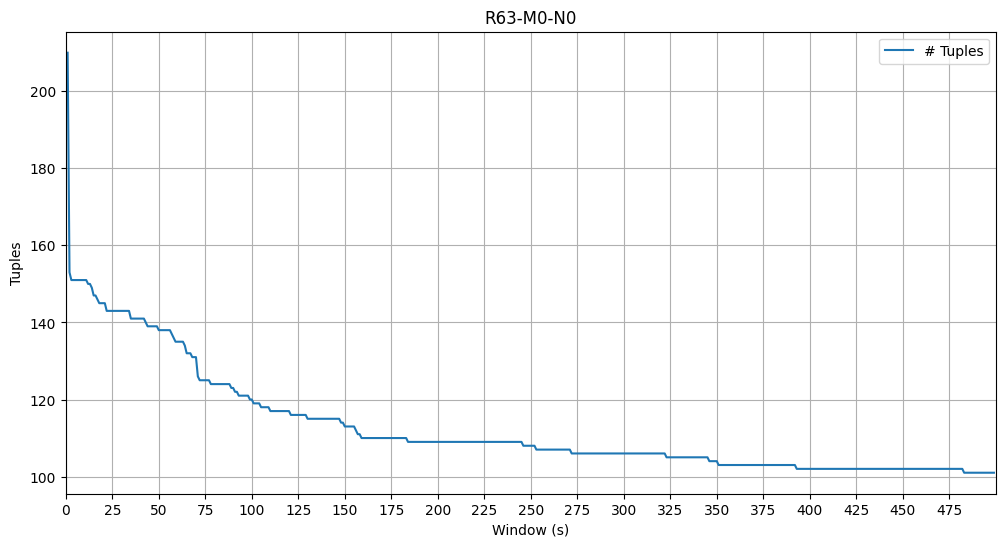

In [39]:
# x_dict = {'tg-c401' : 500,
#           'tg-master' : 500,
#           'tg-c572' : 500,
#           'tg-s044' : 500,
#           'tg-c238' : 500}

for node in top_node:
    filepath = './data/nodes/BGL-' + node + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples')
    plt.title(node)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("./img/nodes/BGL_Node_Sensitivity" + node +".svg", format = "svg")
    plt.show()

In [40]:
win_dict = {'R71-M0-N4' : 175,
            'R12-M0-N0' : 175,
            'R63-M0-N2' : 10,
            'R03-M1-NF' : 5,
            'R63-M0-N0' : 175}

print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'R71-M0-N4': 175, 'R12-M0-N0': 175, 'R63-M0-N2': 10, 'R03-M1-NF': 5, 'R63-M0-N0': 175}


#### Tupling

In [41]:
dict_df_node_stat = {}
dict_node_num_tup = {}

for node in top_node:
    df_temp = df_bgl.loc[df_bgl['ID-Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = './data/nodes//BGL-' + node + '-Data.csv'
   
    df_tupling = tupling(df_temp, win_dict[node], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_node_num_tup[node] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_node_stat[node] = df_stat
    
print('Number of tuples:', dict_node_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'R71-M0-N4': 76, 'R12-M0-N0': 79, 'R63-M0-N2': 7, 'R03-M1-NF': 8, 'R63-M0-N0': 110}


/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(df_stat, ignore_index = True)
/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/1049074867.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

## Data Analysis

### Empirical reliability

In [42]:
top_tup_node = [k for k in dict_node_num_tup if dict_node_num_tup[k] > 30]

for node in top_tup_node:
    ecdf = ECDF(dict_df_node_stat[node]['Interarrival'].dropna())

    tempi_int = pd.DataFrame(dict_df_node_stat[node]['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
    np.savetxt(r'./scripts_matlab/nodes/tempi_int'+node+'.txt', tempi_int, fmt='%d')

df = pd.DataFrame(top_tup_node)
df.to_excel('./scripts_matlab/nodes/names.xls')

/var/folders/cg/p8ldqvbj2qn3mrs4knddvb9c0000gn/T/ipykernel_1778/3132695421.py:10: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel('./scripts_matlab/nodes/names.xls')
